# Learning Gaussian Process regression parameters using gradient descent
> How to learn the parameters of a GP

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

[![](http://img.youtube.com/vi/zBG1BHtipIY/0.jpg)](http://www.youtube.com/watch?v=zBG1BHtipIY "")


In previous posts, I have talked about GP regression:

- [Post 1 on programatically understanding GPs](https://nipunbatra.github.io/blog/ml/2019/08/20/Gaussian-Processes.html)
- [Post 2 on making use of a popular GP library called GPy](https://nipunbatra.github.io/blog/ml/2020/03/26/gp.html)

In this post, I will be talking about how to learn the parameters of a GP. I'll keep this post simple and specific to a trivial example using RBF kernel (though the methods discussed are general.)

To keep things simple, we will assume a mean prior of zero and we will only be learning the parameters of the kernel function. 

### Key Idea

1. Write the expression of log likelihood of data in terms of kernel parameters
2. Use gradient descent to optimize the objective (negative log likelihood) and update the kernel parameters

### Defining log-likelihood

In our previous post we had mentioned (for the **noiseless case**):

Given train data
$$
D=\left(x_{i}, y_{i}\right), i=1: N
$$
Given a test set $X_{*}$ of size $N_{*} \times d$ containing $N_{*}$ points in $\mathbb{R}^{d},$ we want to predict function outputs $y_{*}$
We can write:
$$
\left(\begin{array}{l}
y \\
y_{*}
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{l}
\mu \\
\mu_{*}
\end{array}\right),\left(\begin{array}{cc}
K & K_{*} \\
K_{*}^{T} & K_{* *}
\end{array}\right)\right)
$$
where
$$
\begin{aligned}
K &=\operatorname{Ker}(X, X) \in \mathbb{R}^{N \times N} \\
K_{*} &=\operatorname{Ker}\left(X, X_{*}\right) \in \mathbb{R}^{N \times N} \\
K_{* *} &=\operatorname{Ker}\left(X_{*}, X_{*}\right) \in \mathbb{R}^{N_{*} \times N_{*}}
\end{aligned}
$$

Thus, from the property of conditioning of multivariate Gaussian, we know that:

$$y \sim \mathcal{N}_N(\mu, K)$$

We will assume $\mu$ to be zero. Thus, we have for the train data, the following expression:

$$y \sim \mathcal{N}_N(0, K)$$

For the **noisy case**, we have:

$$y \sim \mathcal{N}_N(0, K + \sigma_{noise}^2\mathcal{I}_N)$$

From this expression, we can write the log-likelihood of data computed over the kernel parameters $\theta$ as:

$$\mathcal{LL}(\theta) = \log(\frac{\exp((-1/2)(y-0)^T (K+\sigma_{noise}^2\mathcal{I}_N)^{-1}(y-0))}{(2\pi)^{N/2}|(K+\sigma_{noise}^2\mathcal{I}_N)|^{1/2}})$$

Thus, we can write:

$$\mathcal{LL}(\theta) =\log P(\mathbf{y} | X, \theta)=-\frac{1}{2} \mathbf{y}^{\top} M^{-1} \mathbf{y}-\frac{1}{2} \log |M|-\frac{N}{2} \log 2 \pi$$

where $$M = K + \sigma_{noise}^2\mathcal{I}_N$$

### Imports

As before, we will be using the excellent Autograd library for automatically computing the gradient of an objective function with respect to the parameters. We will also be using GPy for verifying our calculations.

Let us start with some basic imports.

In [1]:
import autograd.numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import GPy

### Defining our RBF kernel



The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x_1,x_2) = \sigma^2\exp\left(-\frac{(x_1-x_2)^2}{2\mathscr{l}^2}\right)
$$


In [2]:
def rbf(x1, x2, sigma, l):
    return (sigma**2)*(np.exp(-(x1-x2)**2/(2*(l**2))))    

### Defining GPy's RBF kernel

In [3]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


### Matching our RBF kernel with GPy's kernel

In [4]:
rbf(1, 0, 1, 1)==k.K(np.array([[1]]), np.array([[0]])).flatten()

array([ True])

Looks good. Our function is matching GPy's kernel.

### GP Regresion

#### Creating a data set

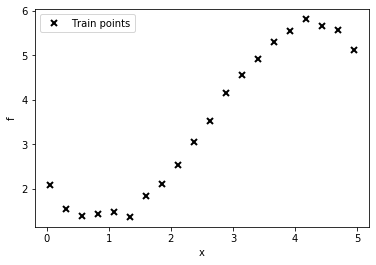

In [5]:
# lambda function, call f(x) to generate data
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2
n = 20
np.random.seed(0)
X = np.linspace(0.05, 4.95, n)[:,None]
Y = f(X) + np.random.normal(0., 0.1, (n,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01
plt.plot(X, Y, "kx", mew=2, label='Train points')
plt.xlabel("x"), plt.ylabel("f")
plt.legend();

### Function to compute negative log likelihood

Based on our above mentioned theory, we can now write the NLL function as follows

In [6]:
def nll(sigma=1, l=1, noise_std=1):
    n = X.shape[0]
    cov = rbf(X, X.T, sigma, l) + (noise_std**2)*np.eye(X.shape[0])
    nll_ar =  0.5*(Y.T@np.linalg.inv(cov)@Y) + 0.5*n*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov)) 
    return nll_ar[0,0]

### Comparing the NLL from our method with the NLL from GPy

We will now compare the NLL from our method with GPy for a fixed set of parameters

In [7]:
nll(1, 1, 1)

40.103960984801276

In [8]:
k.lengthscale = 1
k.variance = 1
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.Gaussian_noise = 1
print(m)


Name : GP regression
Objective : 40.103961039553916
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Excellent, we can see that our method gives the same NLL. Looks like we are on the right track! One caveat here is that I have set the normalizer to be False, which means that GPy will not be mean centering the data.

### Optimizing the GP using GPy

We will now use GPy to optimize the GP parameters

In [9]:
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.optimize()
print(m)


Name : GP regression
Objective : -2.9419881541130053
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    27.837243180547883  |      +ve      |        
  rbf.lengthscale          |     2.732180018958835  |      +ve      |        
  Gaussian_noise.variance  |  0.007573211752763481  |      +ve      |        


It seems that variance close to 28 and length scale close to 2.7 give the optimum objective for the GP

### Plotting the NLL as a function of variance and lenghtscale

We will now plot the NLL obtained from our calculations as a function of variance and lengthscale. For comparing our solution with GPy solution, I will be setting noise variance to be 0.0075

In [10]:
import numpy as numpy
x_grid_2, y_grid_2 = numpy.mgrid[0.1:6:0.04, 0.1:4:0.03]

li = np.zeros_like(x_grid_2)
for i in range(x_grid_2.shape[0]):
    for j in range(x_grid_2.shape[1]):
        li[i, j] = nll(x_grid_2[i, j], y_grid_2[i, j], np.sqrt(.007573211752763481))

Text(0.5, 1.0, 'NLL ($\\sigma, l$)')

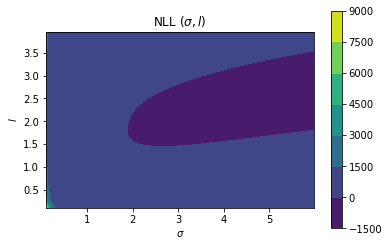

In [11]:
plt.contourf(x_grid_2, y_grid_2, li)
plt.gca().set_aspect('equal')
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$l$")
plt.colorbar()
plt.title(r"NLL ($\sigma, l$)")

We will now try to find the "optimum" $\sigma$ and lengthscale from this NLL space.

In [12]:
print(li.min())
aa, bb = np.unravel_index(li.argmin(), li.shape)
print(x_grid_2[aa, 0]**2, y_grid_2[bb, 0])

-2.9418973674348727
28.09 0.1


Excellent, it looks like we are pretty close to the optimum NLL as reported by GPy and our parameters learnt are also pretty similar. But, we have not even done a thorough search. We will now be using gradient descent to help us find the optimum set of parameters.

### Gradient descent using autograd

In [13]:
from autograd import elementwise_grad as egrad
from autograd import grad

In [14]:
grad_objective = grad(nll, argnum=[0, 1, 2])

#### Visualising the objective as a function of iteration

In [15]:
sigma = 2.
l = 2.
noise = 1.
lr = 1e-3
num_iter = 100
nll_arr = np.zeros(num_iter)
for iteration in range(num_iter):
    nll_arr[iteration] = nll(sigma, l, noise)
    del_sigma, del_l, del_noise = grad_objective(sigma, l, noise)
    sigma = sigma - lr*del_sigma
    l = l - lr*del_l
    noise = noise - lr*del_noise

In [16]:
print(sigma**2, l, noise)

5.108812267877177 1.9770216805277476 0.11095385387537618


Text(0, 0.5, 'NLL')

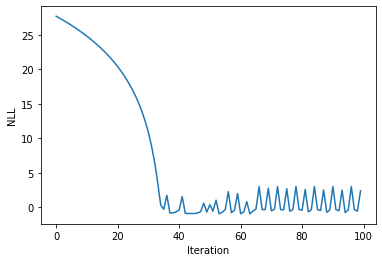

In [17]:
plt.plot(nll_arr)
plt.xlabel("Iteration")
plt.ylabel("NLL")

#### Applying gradient descent and visualising the learnt function

In [19]:
sigma = 2.
l = 2.
noise = 1.
lr = 1e-3
num_iter = 100
nll_arr = np.zeros(num_iter)
fig, ax = plt.subplots()
for iteration in range(num_iter):
    nll_arr[iteration] = nll(sigma, l, noise)
    del_sigma, del_l, del_noise = grad_objective(sigma, l, noise)
    sigma = sigma - lr*del_sigma
    l = l - lr*del_l
    noise = noise - lr*del_noise
    k.lengthscale = l
    k.variance = sigma**2
    m = GPy.models.GPRegression(X, Y, k, normalizer=False)
    m.Gaussian_noise = noise**2
    m.plot(ax=ax)['dataplot'];
    plt.ylim((0, 6))
    plt.title(f"Iteration: {iteration:04}, Objective :{nll_arr[iteration]}")
    plt.savefig(f"/home/nipunbatra-pc/Desktop/gp_learning/{iteration:04}.png")
    plt.cla();
plt.clf()

<Figure size 432x288 with 0 Axes>

In [20]:
!convert -delay 20 -loop 0 /home/nipunbatra-pc/Desktop/gp_learning/*.png gp-learning.gif

![](gp-learning.gif)

Excellent, we can see the "learning" process over time. Our final objective is comparable to GPy's objective.

There are a few things I have mentioned, yet have not gone into their details and I would encourage you to try those out. 

1. First, you should try the gradient descent procedure with restarts. Run with different random initialisations and finally report the parameters which give the optimum likelihood.
2. We assume mean zero prior here. However, we are not processing the data and thus the zero mean assumption is not very well suited to our data. If you reduce the number of data points, you would quickly see the GP prediction to fall close to zero.



There you go. Till next time!